# Pytorch ensemble

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.4 MB/s eta 0:00:00

Using full imbalanced dataset. Class distribution:
sentiment
negative    6620
positive    2039
neutral     1663
Name: count, dtype: int64

Extracting features from the full dataset...


100%|██████████| 10322/10322 [03:03<00:00, 56.31it/s]
[I 2025-08-20 03:48:21,149] A new study created in memory with name: no-name-3be815cb-86d8-41a9-abbe-29272bc3b1ab



--- PART 1: Starting Hyperparameter Search with Optuna ---


[I 2025-08-20 03:48:47,544] Trial 0 finished with value: 0.7823361823361823 and parameters: {'conv1_filters': 128, 'conv2_filters': 256, 'lstm_units': 128, 'dropout': 0.30401902591485513, 'focal_gamma': 1.8327338604956367, 'lr': 0.0024542281841373665}. Best is trial 0 with value: 0.7823361823361823.
[I 2025-08-20 03:49:11,879] Trial 1 finished with value: 0.7891737891737892 and parameters: {'conv1_filters': 128, 'conv2_filters': 128, 'lstm_units': 128, 'dropout': 0.2674942423523225, 'focal_gamma': 2.141870013328642, 'lr': 0.00017647796313897198}. Best is trial 1 with value: 0.7891737891737892.
[I 2025-08-20 03:49:47,252] Trial 2 finished with value: 0.7156695156695156 and parameters: {'conv1_filters': 128, 'conv2_filters': 256, 'lstm_units': 256, 'dropout': 0.3964252476312402, 'focal_gamma': 1.7487842282032928, 'lr': 0.004415654681232052}. Best is trial 1 with value: 0.7891737891737892.
[I 2025-08-20 03:50:12,187] Trial 3 finished with value: 0.7612535612535613 and parameters: {'conv1_


Optuna search complete. Best parameters found:
{'conv1_filters': 128, 'conv2_filters': 128, 'lstm_units': 128, 'dropout': 0.23265518178485783, 'focal_gamma': 1.5481662017221482, 'lr': 0.0003782195384596158}

--- PART 2: Training an ensemble of 5 models with the best parameters ---

Training model 1/5...

Training model 2/5...

Training model 3/5...

Training model 4/5...

Training model 5/5...

--- PART 3: Evaluating the ensemble of 5 models on the hold-out test set ---

--- Final Ensemble Classification Report ---
              precision    recall  f1-score   support

    negative       0.86      0.90      0.88       993
     neutral       0.73      0.78      0.75       250
    positive       0.75      0.58      0.66       306

    accuracy                           0.82      1549
   macro avg       0.78      0.75      0.76      1549
weighted avg       0.82      0.82      0.81      1549



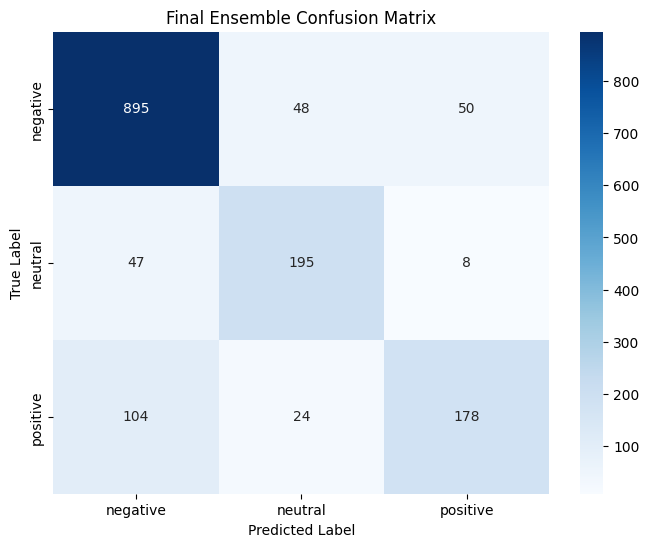

In [ ]:
# =============================================================================
# STEP 1: SETUP, LIBRARIES & DATA PREPARATION
# =============================================================================
!pip install optuna -q # Install Optuna
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import kagglehub
import optuna

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# --- Setup Device (GPU/CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

## Data Loading and Processing

This section downloads and processes the RAVDESS and CREMA-D datasets. The audio files are loaded, and sentiment labels are extracted based on the filenames. The datasets are then combined and the full, imbalanced dataset is used for training with Focal Loss.

In [ ]:
# --- Download & Process Datasets ---
RAVDESS_PATH = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
CREMA_D_PATH = kagglehub.dataset_download("ejlok1/cremad")

sentiment_map = {'happy': 'positive', 'surprised': 'positive', 'sad': 'negative', 'angry': 'negative', 'fearful': 'negative', 'disgust': 'negative', 'neutral': 'neutral', 'calm': 'neutral'}
ravdess_emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
ravdess_data = []
for dirpath, _, filenames in os.walk(RAVDESS_PATH):
    for filename in filenames:
        if filename.endswith('.wav'):
            emotion_code = filename.split('-')[2]; emotion = ravdess_emotion_map.get(emotion_code); sentiment = sentiment_map.get(emotion)
            if sentiment: ravdess_data.append({"filepath": os.path.join(dirpath, filename), "sentiment": sentiment})
ravdess_df = pd.DataFrame(ravdess_data)

crema_emotion_map = {'HAP': 'happy', 'SAD': 'sad', 'ANG': 'angry', 'FEA': 'fearful', 'DIS': 'disgust', 'NEU': 'neutral'}
crema_data = []
crema_audio_path = os.path.join(CREMA_D_PATH, "AudioWAV")
for filename in os.listdir(crema_audio_path):
    if filename.endswith('.wav'):
        emotion_code = filename.split('_')[2]; emotion = crema_emotion_map.get(emotion_code); sentiment = sentiment_map.get(emotion)
        if sentiment: crema_data.append({"filepath": os.path.join(crema_audio_path, filename), "sentiment": sentiment})
crema_df = pd.DataFrame(crema_data)

# --- Use the FULL, IMBALANCED dataset for Focal Loss ---
combined_df = pd.concat([ravdess_df, crema_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("\nUsing full imbalanced dataset. Class distribution:")
print(combined_df['sentiment'].value_counts())

## Feature Extraction and Dataset Class

This section defines the `extract_features` function to extract MFCCs, delta MFCCs, and delta-delta MFCCs from the audio files. It also defines the `SpeechDataset` class to handle the features and labels, preparing the data for use with PyTorch DataLoaders.

In [ ]:
# --- Define Helper Classes and Functions ---
def extract_features(file_path, n_mfcc=40, max_pad_len=216):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast', sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta_mfccs = librosa.feature.delta(mfccs); delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        all_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        if all_features.shape[1] > max_pad_len: all_features = all_features[:, :max_pad_len]
        else: all_features = np.pad(all_features, ((0, 0), (0, max_pad_len - all_features.shape[1])), mode='constant')
    except Exception as e: return None
    return all_features

class SpeechDataset(Dataset):
    def __init__(self, features, labels):
        self.features = [torch.tensor(f, dtype=torch.float32) for f in features]
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.labels[idx]

# --- Feature Extraction (run once) ---
print("\nExtracting features from the full dataset...")
X_features = [extract_features(fp) for fp in tqdm(combined_df['filepath'])]
y_labels = combined_df['sentiment'].tolist()
X_filtered = [x for x in X_features if x is not None]; y_filtered = [y for x, y in zip(X_features, y_labels) if x is not None]
le = LabelEncoder(); y_encoded = le.fit_transform(y_filtered)

# --- Final Data Split ---
# We create a final hold-out test set ONCE.
X_train_val, X_test, y_train_val, y_test = train_test_split(X_filtered, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)
test_dataset = SpeechDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Definition and Hyperparameter Search with Optuna

This section defines the `FocalLoss` class and the `Attention` module. It also defines the `define_model` function for Optuna's hyperparameter search and the `objective` function that Optuna will optimize. The Optuna study is created and optimized to find the best hyperparameters.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__(); self.alpha = alpha; self.gamma = gamma; self.reduction = reduction
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none'); pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__(); self.attention = nn.Linear(hidden_size, 1, bias=False)
    def forward(self, lstm_output):
        scores = self.attention(lstm_output).squeeze(2); weights = F.softmax(scores, dim=1).unsqueeze(1)
        return torch.bmm(weights, lstm_output).squeeze(1)

def define_model(trial, input_shape, num_classes):
    # Suggest hyperparameters for the model architecture
    conv1_filters = trial.suggest_categorical("conv1_filters", [64, 128])
    conv2_filters = trial.suggest_categorical("conv2_filters", [128, 256])
    lstm_units = trial.suggest_categorical("lstm_units", [128, 256])
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)

    class SpeechModel(nn.Module): # Define inside so it gets recreated with new params
        def __init__(self):
            super(SpeechModel, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv1d(input_shape[0], conv1_filters, 5, padding='same'), nn.BatchNorm1d(conv1_filters), nn.ReLU(), nn.MaxPool1d(2), nn.Dropout(dropout_rate),
                nn.Conv1d(conv1_filters, conv2_filters, 5, padding='same'), nn.BatchNorm1d(conv2_filters), nn.ReLU(), nn.MaxPool1d(2), nn.Dropout(dropout_rate))
            with torch.no_grad():
                dummy_output = self.conv_layers(torch.zeros(1, input_shape[0], input_shape[1]))
            lstm_input_size = dummy_output.shape[1]
            self.lstm = nn.LSTM(lstm_input_size, lstm_units, batch_first=True, bidirectional=True)
            self.attention = Attention(lstm_units * 2)
            self.classifier = nn.Sequential(nn.Linear(lstm_units * 2, 128), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(128, num_classes))
        def forward(self, x):
            x = self.conv_layers(x).permute(0, 2, 1); lstm_out, _ = self.lstm(x)
            return self.classifier(self.attention(lstm_out))
    return SpeechModel()

def objective(trial):
    # --- Data for this trial ---
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
    train_dataset = SpeechDataset(X_train, y_train); val_dataset = SpeechDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # --- Model, Loss, Optimizer ---
    INPUT_SHAPE = (120, 216); NUM_CLASSES = len(le.classes_)
    model = define_model(trial, INPUT_SHAPE, NUM_CLASSES).to(device)

    focal_gamma = trial.suggest_float("focal_gamma", 1.5, 3.0)
    criterion = FocalLoss(gamma=focal_gamma)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # --- Training Loop ---
    best_val_acc = 0
    for epoch in range(15): # A shorter run for hyperparameter search
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device); optimizer.zero_grad()
            outputs = model(features); loss = criterion(outputs, labels); loss.backward(); optimizer.step()

        model.eval(); val_correct = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                val_correct += (torch.max(model(features).data, 1)[1] == labels).sum().item()
        val_acc = val_correct / len(val_dataset)
        if val_acc > best_val_acc: best_val_acc = val_acc

    return best_val_acc

print("\n--- PART 1: Starting Hyperparameter Search with Optuna ---")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) # Increase trials for better search
best_params = study.best_params
print("\nOptuna search complete. Best parameters found:")
print(best_params)

## Ensemble Training

This section trains an ensemble of models using the best hyperparameters found by Optuna. Each model in the ensemble is trained on a different train/validation split of the data to promote diversity.

In [ ]:
# =============================================================================
# PART 2: TRAIN THE ENSEMBLE
# =============================================================================
N_ENSEMBLE = 5
print(f"\n--- PART 2: Training an ensemble of {N_ENSEMBLE} models with the best parameters ---")

def create_final_model(params, input_shape, num_classes):
    # Recreate the model structure using the BEST params from Optuna
    class FinalModel(nn.Module):
        def __init__(self):
            super(FinalModel, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv1d(input_shape[0], params['conv1_filters'], 5, padding='same'), nn.BatchNorm1d(params['conv1_filters']), nn.ReLU(), nn.MaxPool1d(2), nn.Dropout(params['dropout']),
                nn.Conv1d(params['conv1_filters'], params['conv2_filters'], 5, padding='same'), nn.BatchNorm1d(params['conv2_filters']), nn.ReLU(), nn.MaxPool1d(2), nn.Dropout(params['dropout']))
            with torch.no_grad(): dummy_output = self.conv_layers(torch.zeros(1, input_shape[0], input_shape[1]))
            lstm_input_size = dummy_output.shape[1]
            self.lstm = nn.LSTM(lstm_input_size, params['lstm_units'], batch_first=True, bidirectional=True)
            self.attention = Attention(params['lstm_units'] * 2)
            self.classifier = nn.Sequential(nn.Linear(params['lstm_units'] * 2, 128), nn.ReLU(), nn.Dropout(params['dropout']), nn.Linear(128, num_classes))
        def forward(self, x):
            x = self.conv_layers(x).permute(0, 2, 1); lstm_out, _ = self.lstm(x)
            return self.classifier(self.attention(lstm_out))
    return FinalModel()

for i in range(N_ENSEMBLE):
    print(f"\nTraining model {i+1}/{N_ENSEMBLE}...")
    # Get a different train/val split for each model
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=i, stratify=y_train_val)
    train_dataset = SpeechDataset(X_train, y_train); val_dataset = SpeechDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = create_final_model(best_params, (120, 216), len(le.classes_)).to(device)
    criterion = FocalLoss(gamma=best_params['focal_gamma'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['lr'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf'); patience_counter = 0
    for epoch in range(60): # Full training run
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device); optimizer.zero_grad()
            outputs = model(features); loss = criterion(outputs, labels); loss.backward(); optimizer.step()

        model.eval(); val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device); val_loss += criterion(model(features), labels).item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss; torch.save(model.state_dict(), f'ensemble_model_{i}.pth'); patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 10: break # Early stopping

## Ensemble Evaluation

This section evaluates the trained ensemble of models on the hold-out test set. The predictions from each model are averaged (in terms of probabilities) to make the final prediction. The classification report and confusion matrix are then displayed to assess the ensemble's performance.

In [ ]:
# =============================================================================
# PART 3: EVALUATE THE ENSEMBLE
# =============================================================================
print(f"\n--- PART 3: Evaluating the ensemble of {N_ENSEMBLE} models on the hold-out test set ---")
models = []
for i in range(N_ENSEMBLE):
    model = create_final_model(best_params, (120, 216), len(le.classes_)).to(device)
    model.load_state_dict(torch.load(f'ensemble_model_{i}.pth'))
    model.eval()
    models.append(model)

all_preds, all_labels = [], []
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        # Get predictions from all models in the ensemble
        all_model_probs = [F.softmax(model(features), dim=1) for model in models]
        # Average the probabilities
        mean_probs = torch.mean(torch.stack(all_model_probs), dim=0)
        # Get the final prediction
        _, predicted = torch.max(mean_probs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n--- Final Ensemble Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=le.classes_))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Final Ensemble Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()